In [3]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt 

ModuleNotFoundError: No module named 'mxnet'

In [3]:
pip install d2l

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simpleNote: you may need to restart the kernel to use updated packages.



In [5]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [6]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [7]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.12075 sec'

In [8]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

In [9]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

In [20]:
import torch
import d2l  # 导入 d2l-pytorch（安装后会自动识别 PyTorch 环境）

# 定义正态分布概率密度函数（使用 PyTorch 张量）
def normal(x, mu, sigma):
    p = 1 / torch.sqrt(2 * torch.pi * sigma**2)
    return p * torch.exp(-(x - mu)**2 / (2 * sigma**2))

# 生成数据（PyTorch 张量）
x = torch.arange(-7, 7, 0.01, dtype=torch.float32)
params = [(0, 1), (0, 2), (3, 1)]

# 绘图（若 d2l-pytorch 支持 plot 方法）
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], 
         xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

AttributeError: module 'd2l' has no attribute 'plot'

In [15]:
pip uninstall -y d2l 

Found existing installation: d2l 1.0.3
Uninstalling d2l-1.0.3:
  Successfully uninstalled d2l-1.0.3
Note: you may need to restart the kernel to use updated packages.


In [21]:
import d2l
print(d2l.__file__)  # 输出路径应包含 "d2l-pytorch" 字样

E:\Anaconda\pytorch\lib\site-packages\d2l\__init__.py


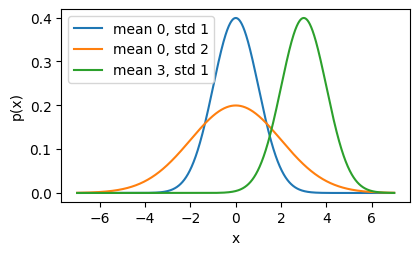

In [23]:
import torch
import matplotlib.pyplot as plt

def normal(x, mu, sigma):
    # 将 mu 和 sigma 转换为与 x 同类型的张量（避免类型不匹配）
    mu = torch.tensor(mu, dtype=x.dtype)
    sigma = torch.tensor(sigma, dtype=x.dtype)
    p = 1 / torch.sqrt(2 * torch.pi * sigma**2)
    return p * torch.exp(-(x - mu)**2 / (2 * sigma**2))

# 生成 x 轴数据（PyTorch 张量）
x = torch.arange(-7, 7, 0.01, dtype=torch.float32)
params = [(0, 1), (0, 2), (3, 1)]  # (均值, 标准差)

# 绘制曲线
plt.figure(figsize=(4.5, 2.5))
for mu, sigma in params:
    y = normal(x, mu, sigma)
    plt.plot(x.numpy(), y.numpy(), label=f'mean {mu}, std {sigma}')  # 转换为 numpy 数组绘图
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()
plt.show()

In [24]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [25]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [26]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.6259, -0.3363]) 
label: tensor([4.0914])


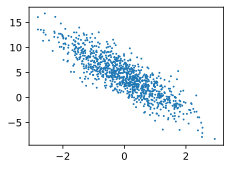

In [27]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [28]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [29]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.4682,  1.4645],
        [ 0.7542, -1.5047],
        [-1.0714, -0.3088],
        [-0.8086,  1.0714],
        [-1.2198, -0.6872],
        [-0.2935,  2.0318],
        [ 0.3633,  1.4396],
        [-0.9262, -0.1613],
        [-0.4445,  0.9083],
        [ 2.5039, -0.5702]]) 
 tensor([[ 0.1471],
        [10.8300],
        [ 3.0968],
        [-1.0587],
        [ 4.0946],
        [-3.2723],
        [ 0.0174],
        [ 2.8917],
        [ 0.2204],
        [11.1480]])


In [30]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [31]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [32]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [33]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [34]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.032950
epoch 2, loss 0.000118
epoch 3, loss 0.000052


In [35]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-2.9063e-04,  8.3447e-06], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


In [36]:
from mxnet import autograd, gluon, np, npx
from d2l import mxnet as d2l

npx.set_np()

true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

ModuleNotFoundError: No module named 'mxnet'

In [4]:
pip install mxnet

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/2a/4f/fc1adda6d1ceef5c9b3921e6c6d208b86b1b3ed61686a84c1b1bcc821798/mxnet-1.7.0.post2-py2.py3-none-win_amd64.whl (33.1 MB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/b7/6f/24647f014eef9b67a24adfcbcd4f4928349b4a0f8393b3d7fe648d4d2de3/numpy-1.16.6.zip (5.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/49/df/50aa1999ab9bde74656c2919d9c0c085fd2b3775fd3eca826012bef76d8c/requests-2.18.4-py2.py3-none-any.whl (88 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/53/39/4ab213673844e0c004bed8a0781a0721a3f6bb23eb8854ee75c236428892/graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/27/cc/6dd9a3869f15c2edfab863b992838277279ce92663d334df9ecf5106f5c6/idna-2.6-py2.py3-none-any.whl (56 kB)
  Us

  DEPRECATION: Building 'numpy' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'numpy'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [15 lines of output]
  Running from numpy source directory.
  C:\Users\25303\AppData\Local\Temp\pip-install-6r2fvvar\numpy_494ed528f9a847f3a3a799efa3805651\numpy\distutils\misc_util.py:476: SyntaxWarning: "is" with a literal. Did you mean "=="?
    return is_string(s) and ('*' in s or '?' is s)
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 35, in <module

In [39]:
pip install --upgrade pip setuptools wheel

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip cache purge

ERROR: No matching packages


In [6]:
pip install --use-pep517 mxnet

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/2a/4f/fc1adda6d1ceef5c9b3921e6c6d208b86b1b3ed61686a84c1b1bcc821798/mxnet-1.7.0.post2-py2.py3-none-win_amd64.whl (33.1 MB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/b7/6f/24647f014eef9b67a24adfcbcd4f4928349b4a0f8393b3d7fe648d4d2de3/numpy-1.16.6.zip (5.1 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [24 lines of output]
  Running from numpy source directory.
  <string>:394: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
  C:\Users\25303\AppData\Local\Temp\pip-install-se2hggc2\numpy_4ea67ab38b2c48728a6b9e65545b303b\numpy\distutils\misc_util.py:476: SyntaxWarning: "is" with a literal. Did you mean "=="?
    return is_string(s) and ('*' in s or '?' is s)
  Traceback (most recent call last):
    File "E:\Anaconda\pytorch\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
      main()
    File "E:\Anaconda\pytorch\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
      json_out["return_val"] = hook(**hook_input["kwargs"])
    File "E:\Anaconda\pytorch\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in

In [17]:
%matplotlib inline  
import torch
import d2l  

ModuleNotFoundError: No module named 'd2l'

In [20]:
!where python 


D:\Anaconda\python.exe
E:\文件\华为班\数据集处理\chatterbot_chatbot-master\venv\Scripts\python.exe
C:\Users\25303\AppData\Local\Microsoft\WindowsApps\python.exe
